In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!wget https://raw.githubusercontent.com/riya0920/DeepLearning_TensorFlow/main/helper_functions.py

--2023-04-05 12:19:15--  https://raw.githubusercontent.com/riya0920/DeepLearning_TensorFlow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11134 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.87K  --.-KB/s    in 0s      

2023-04-05 12:19:15 (72.5 MB/s) - ‘helper_functions.py’ saved [11134/11134]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
dataset_lists = tfds.list_builders()
print("food101" in dataset_lists)

True


In [ ]:
(train_data,test_data),ds_info = tfds.load(name="food101",
                                           split=["train","validation"],
                                           shuffle_files = True,
                                           as_supervised = True,
                                           with_info = True)

In [ ]:
info = ds_info.features
info

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data_sample = train_data.take(1)
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in train_data_sample:
  print(f"""
  Image shape = {image.shape}
  Label name = {class_names[label.numpy()]}
  Image Datatype = {image.dtype}
  Class = {label}
  """)


  Image shape = (384, 512, 3)
  Label name = pad_thai
  Image Datatype = <dtype: 'uint8'>
  Class = 70
  


Text(0.5, 1.0, 'pad_thai')

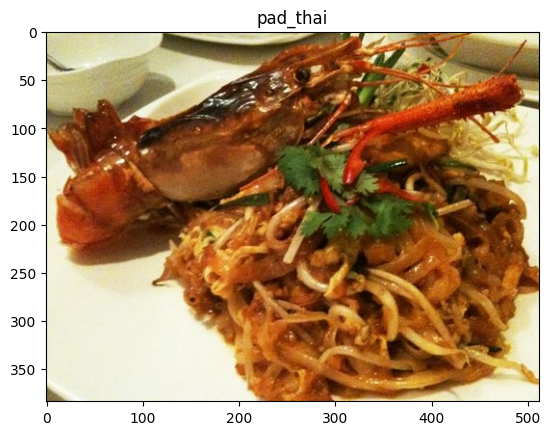

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])

In [ ]:
def preprocessing(image,label,image_shape=224):
  image = tf.image.resize(image,size = [image_shape,image_shape])
  image = image/255.
  return tf.cast(image,tf.float32),label##############################################################################################################

In [ ]:
(image,label)=preprocessing(image,label)
print(f"Image shape: {image.shape}\n Image dtype: {image.dtype}")#####################################################################################

Image shape: (224, 224, 3)
 Image dtype: <dtype: 'float32'>


In [ ]:
train_data = train_data.map(map_func = preprocessing,num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE) #buffer size means the number of images it would shuffle at the same time!!!

test_data = test_data.map(map_func = preprocessing,num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:

train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
checkpoint_path = "checkpoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor = "val_accuracy",
                                                         save_best_only = False,
                                                         save_weigts_only = True)

In [ ]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# mixed_precision.global_policy()

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3),name="input layer")
x = base_model(inputs,training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "Average")(x)
outputs = tf.keras.layers.Dense(len(class_names),"softmax")(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are not one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
for layer in model.layers:
  print(f"{layer.name}\n{layer.trainable}\n{layer.dtype}\n{layer.dtype_policy}")

input layer
True
float32
<Policy "float32">
efficientnetb0
False
float32
<Policy "mixed_float16">
Average
True
float32
<Policy "mixed_float16">
dense
True
float32
<Policy "mixed_float16">
Activation
True
float32
<Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(f"{layer.name}, {layer.trainable},{layer.dtype},{layer.dtype_policy}")

input_1, False,float32,<Policy "float32">
rescaling, False,float32,<Policy "mixed_float16">
normalization, False,float32,<Policy "mixed_float16">
rescaling_1, False,float32,<Policy "mixed_float16">
stem_conv_pad, False,float32,<Policy "mixed_float16">
stem_conv, False,float32,<Policy "mixed_float16">
stem_bn, False,float32,<Policy "mixed_float16">
stem_activation, False,float32,<Policy "mixed_float16">
block1a_dwconv, False,float32,<Policy "mixed_float16">
block1a_bn, False,float32,<Policy "mixed_float16">
block1a_activation, False,float32,<Policy "mixed_float16">
block1a_se_squeeze, False,float32,<Policy "mixed_float16">
block1a_se_reshape, False,float32,<Policy "mixed_float16">
block1a_se_reduce, False,float32,<Policy "mixed_float16">
block1a_se_expand, False,float32,<Policy "mixed_float16">
block1a_se_excite, False,float32,<Policy "mixed_float16">
block1a_project_conv, False,float32,<Policy "mixed_float16">
block1a_project_bn, False,float32,<Policy "mixed_float16">
block2a_expand_co

AttributeError: ignored

In [ ]:
history = model.fit(train_data,
                    epochs = 3,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [create_tensorboard_callback("mixed_Precision","model")])

Saving TensorBoard log files to: mixed_Precision/model/20230405-135115
Epoch 1/3
 112/2368 [>.............................] - ETA: 6:12:04 - loss: nan - accuracy: 0.0086

KeyboardInterrupt: ignored